In [1]:
import os
import pandas as pd
from tqdm import tqdm

def read_slice_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image slice files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)
        mask_path = mask_path.split(".")[0] + ".tiff"

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask slice folders
image_slice_folder = "/kaggle/input/lits-slices/kaggle/working/images"
mask_slice_folder = "/kaggle/input/lits-slices/kaggle/working/masks"

# Read slice paths and create a DataFrame
df_slices = read_slice_paths(image_slice_folder, mask_slice_folder)

100%|██████████| 19131/19131 [01:05<00:00, 293.86it/s]


In [2]:
df_slices.head(5)

,Image,Mask
0,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...
1,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...
2,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...
3,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...
4,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...


In [3]:
#sanity check
print(df_slices["Image"][0])
print(df_slices["Mask"][0])

/kaggle/input/lits-slices/kaggle/working/images/volume-126_slice_228.jpg
/kaggle/input/lits-slices/kaggle/working/masks/volume-126_slice_228.tiff


In [4]:
#for multiclass
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                #mask = mask.astype(np.int32)
    

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        #masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        masks = np.array(tf.one_hot(masks, 3, dtype = tf.float32))
        return  images, masks

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(df_slices, batch_size=8, image_size=(256, 256), shuffle=True)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


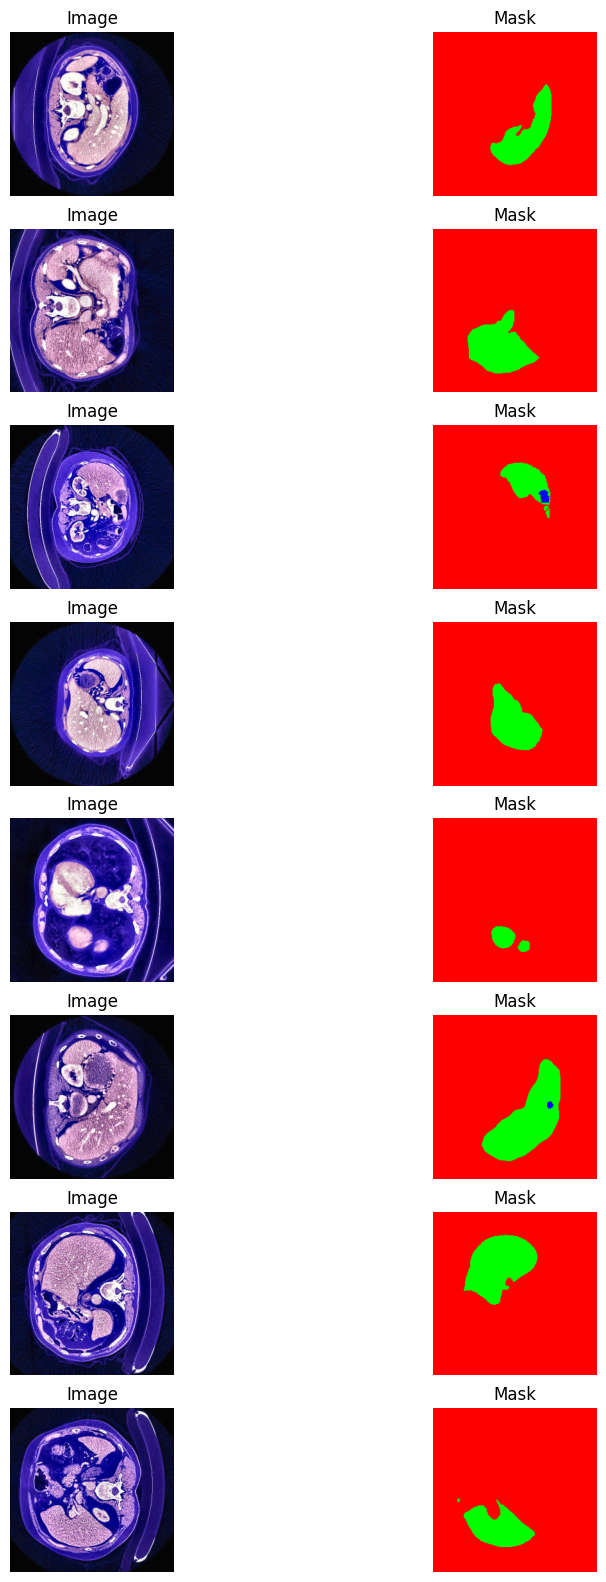

In [5]:
import matplotlib.pyplot as plt

# Load a single batch
batch = train_generator[0]  # Assuming you want to load the first batch

# Extract images and labels from the batch
images, masks = batch

# Display the images and masks
n_images_to_display = len(images)
fig, ax = plt.subplots(n_images_to_display, 2, figsize=(10, 20))

for i in range(n_images_to_display):
    ax[i, 0].imshow(images[i], cmap='bone')
    #print(np.max(images[i]))
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(masks[i], cmap='bone')
    #print(np.max(masks[i]))
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()


In [6]:
import cv2
import pandas as pd

# Assuming df_slices is your DataFrame with "Image" and "Mask" columns
# Add the "Num_Classes" column with default value 0
df_slices["Num_Classes"] = 0

# Function to read the mask using cv2 and return the number of unique classes
def read_mask_and_count_classes(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.int32)
    val, counts = np.unique(mask, return_counts=True)
    return len(counts)

# Apply the function to each row in the DataFrame
tqdm.pandas(desc="Processing Masks", unit="mask")
df_slices["Num_Classes"] = df_slices["Mask"].progress_apply(read_mask_and_count_classes)

Processing Masks: 100%|██████████| 19131/19131 [04:25<00:00, 72.16mask/s]


In [7]:
df_slices.head(5)

,Image,Mask,Num_Classes
0,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...,3
1,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...,3
2,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...,2
3,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...,3
4,/kaggle/input/lits-slices/kaggle/working/image...,/kaggle/input/lits-slices/kaggle/working/masks...,2


In [8]:
from sklearn.model_selection import train_test_split

df_shuffled = df_slices.sample(frac=1, random_state=42)

df_train, df_temp = train_test_split(df_shuffled, test_size=0.30, stratify=df_shuffled["Num_Classes"], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.6, stratify=df_temp["Num_Classes"], random_state=42)

In [9]:
unique_values = df_slices['Num_Classes'].unique()
print("Unique values in 'Num_Classes' column:", unique_values)
value_counts = df_slices['Num_Classes'].value_counts(normalize=True)
print("\nRatio of each unique value in 'num_classes' column:",value_counts)

Unique values in 'Num_Classes' column: [3 2]

Ratio of each unique value in 'num_classes' column: Num_Classes
2    0.624536
3    0.375464
Name: proportion, dtype: float64


In [10]:
unique_values = df_train['Num_Classes'].unique()
print("Unique values in 'Num_Classes' column:", unique_values)
value_counts = df_train['Num_Classes'].value_counts(normalize=True)
print("\nRatio of each unique value in 'num_classes' column:",value_counts)

Unique values in 'Num_Classes' column: [2 3]

Ratio of each unique value in 'num_classes' column: Num_Classes
2    0.624524
3    0.375476
Name: proportion, dtype: float64


In [11]:
unique_values = df_val['Num_Classes'].unique()
print("Unique values in 'Num_Classes' column:", unique_values)
value_counts = df_val['Num_Classes'].value_counts(normalize=True)
print("\nRatio of each unique value in 'num_classes' column:",value_counts)

Unique values in 'Num_Classes' column: [2 3]

Ratio of each unique value in 'num_classes' column: Num_Classes
2    0.624564
3    0.375436
Name: proportion, dtype: float64


In [12]:
unique_values = df_test['Num_Classes'].unique()
print("Unique values in 'Num_Classes' column:", unique_values)
value_counts = df_test['Num_Classes'].value_counts(normalize=True)
print("\nRatio of each unique value in 'num_classes' column:",value_counts)

Unique values in 'Num_Classes' column: [3 2]

Ratio of each unique value in 'num_classes' column: Num_Classes
2    0.624564
3    0.375436
Name: proportion, dtype: float64


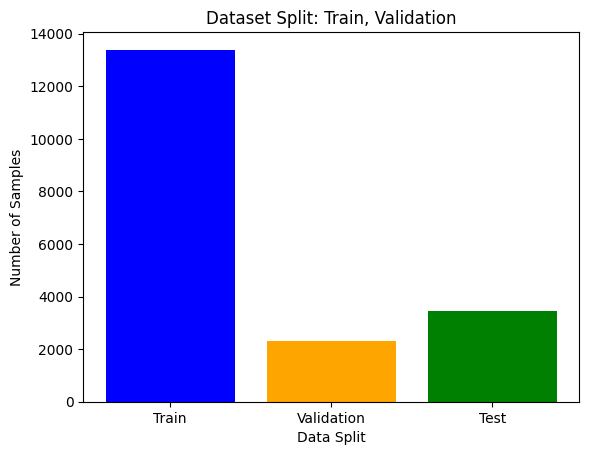

In [13]:
# bar plot
from matplotlib import pyplot as plt
sizes = [len(df_train), len(df_val), len(df_test)]
labels = ['Train', 'Validation', 'Test']

plt.bar(labels, sizes, color=['blue', 'orange', 'green'])
plt.xlabel('Data Split')
plt.ylabel('Number of Samples')
plt.title('Dataset Split: Train, Validation')
plt.show()

# Model Architecture and Helper blocks

In [14]:
#GCSE Block...from the GCSER UNET (Mukherjee et al.)
def GCSE(input_tensor, ratio=16):


    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)

    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu')(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid')(attn_channel)

    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(global_info)

    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply()([attn_channel,attn_spatial])

    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply()([input_tensor,attn])

    return output_tensor

In [15]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [16]:
from tensorflow.keras.applications import ResNet50
def build_encoder2(inputs):

    s=[]
    """ Pre-trained ResNet50 Model """
    resnet50= ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in resnet50.layers:
        layer.trainable = True


    """ Encoder """
    s1 = resnet50.get_layer("model_input").output    
    s.append(s1)
    s2 = resnet50.get_layer("conv1_relu").output   
    s.append(s2)
    s3 = resnet50.get_layer("conv2_block3_out").output  
    s.append(s3)
    s4 = resnet50.get_layer("conv3_block4_out").output  
    s.append(s4)

    """ Bridge """
    #b1 = resnet50.get_layer("conv4_block6_out").output 
    b = resnet50.get_layer("conv4_block2_out").output 
    b = ASPP(b,128)
    
    encoder2 = Model(inputs,outputs=[s,b],name = "encoder2")

    return encoder2

# Asymmetric architecture

In [17]:
# Code for W-Net

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model


"""def complementary_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.math.sigmoid(mse_loss)"""
def complementary_loss(feature_map1,feature_map2):
    # Normalize the feature maps to [0, 1]
    feature_map1 /= tf.reduce_max(feature_map1)
    feature_map2 /= tf.reduce_max(feature_map2)
    m1 = tf.reduce_mean(feature_map1)
    m2  = tf.reduce_mean(feature_map2)

    return tf.math.sigmoid(tf.abs(m1-m2))


def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    #x = Activation("relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)


    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, s1,s2, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x,s1,s2])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x
def build_encoder1(inputs,f):
    
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    c1 = GCSE(c1)
    p1 = MaxPooling2D((2,2))(c1)
    s1 = c1

    c2 = residual_block(p1, f[1])
    c2 = GCSE(c2)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = c2

    c3 = residual_block(p2, f[2])
    c3 = GCSE(c3)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = GCSE(c4)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = c4
    
    s_ = [s1,s2,s3,s4]
    """ Bridge """
    b = ASPP(p4,128)
    encoder1 = Model(inputs,outputs=[s_,b],name="encoder1")
    return encoder1

    
    

def build_WNet(input_shape):
    f = [16,32,64,128]

    inputs = Input(input_shape,name="model_input")
    encoder1 = build_encoder1(inputs,f)
    encoder2 = build_encoder2(inputs)
    s1,b1 = encoder1(inputs)
    s2,b2 = encoder2(inputs)

    b = Concatenate()([b1,b2])

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s2[3],s1[3], f[3]+512)
    d2 = decoder_block(d1, s2[2],s1[2], f[2]+256)
    d3 = decoder_block(d2, s2[1],s1[1], f[1]+64)
    d4 = decoder_block(d3, s2[0],s1[0],f[0]+3)
    
    """comp1 = complementary_loss(s2[0], s1[0])
    comp2 = complementary_loss(s2[1], s1[1])
    comp3 = complementary_loss(s2[2], s1[2])
    comp4 = complementary_loss(s2[3], s1[3])

    

    output_2 = tf.keras.layers.Add(name='output_2')([comp1/4.0,comp2/4.0,comp3/4.0,comp4/4.0])"""

    """ Classifier """
    output_1 = Conv2D(3, (1,1) , activation="softmax",name='output_1')(d4)

    """ Model """
    #model = Model(inputs,outputs=[output_1,output_2])
    model = Model(inputs,outputs=output_1)
    return model

# Evaluation Metrics

In [18]:
from keras import backend as K
def iou_liver(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    targets_f = K.flatten(targets[:,:,:,1])
    inputs_f = K.flatten(inputs[:,:,:,1])
    
    
    intersection = K.sum((targets_f*inputs_f))
    total = K.sum(targets_f) + K.sum(inputs_f)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

def iou_tumor(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    targets_f = K.flatten(targets[:,:,:,2])
    inputs_f = K.flatten(inputs[:,:,:,2])
    
    intersection = K.sum((targets_f * inputs_f))
    total = K.sum(targets_f) + K.sum(inputs_f)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

def iou(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    class_num = 3
    for i in range(class_num):
        targets_f= K.flatten(targets[:,:,:,i])
        inputs_f = K.flatten(inputs[:,:,:,i])
       

        intersection = K.sum((targets_f*inputs_f))
        total = K.sum(targets_f) + K.sum(inputs_f)
        union = total - intersection
        loss = (intersection + smooth) / (union + smooth)
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss
def dice_coef(y_true, y_pred, smooth=1e-5):
    class_num = 3
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss
def dice_coef_liver(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    return loss

def dice_coef_tumor(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true[:,:,:,2])
    y_pred_f = K.flatten(y_pred[:,:,:,2])
    intersection = K.sum(y_true_f * y_pred_f)
    loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    return loss

# Computing Sensitivity      
def sensitivity_liver(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true[:,:,:,1] * y_pred[:,:,:,1], 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true[:,:,:,1], 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def sensitivity_tumor(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true[:,:,:,2] * y_pred[:,:,:,2], 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true[:,:,:,2], 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity_liver(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true[:,:,:,1]) * (1-y_pred[:,:,:,1]), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true[:,:,:,1], 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def specificity_tumor(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true[:,:,:,2]) * (1-y_pred[:,:,:,2]), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true[:,:,:,2], 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def tversky(y_true, y_pred):
    smooth=1
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return (3 - tversky(y_true[:,:,:,0],y_pred[:,:,:,0])-tversky(y_true[:,:,:,1],y_pred[:,:,:,1])-tversky(y_true[:,:,:,2],y_pred[:,:,:,2]))

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true[:,:,:,0],y_pred[:,:,:,0])
    pt_2 = tversky(y_true[:,:,:,1],y_pred[:,:,:,1])
    pt_3 = tversky(y_true[:,:,:,2],y_pred[:,:,:,2])
    
    gamma = 0.75
    return K.pow((3-pt_1-pt_2-pt_3), gamma)

In [19]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [20]:
!pip install -U segmentation-models
#%env SM_FRAMEWORK=tf.keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [21]:
import segmentation_models as sm
dice_loss = sm.losses.DiceLoss(class_weights = [0.33,0.33,0.33]) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

Segmentation Models: using `tf.keras` framework.


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
model = build_WNet((256,256,3))
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)

94765736/94765736 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 model_input (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder1 (Functional)       [[(None, 256, 256, 16),      870567    ['model_input[0][0]']         
                              (None, 128, 128, 32),                                               
                              (None, 64, 64, 64),                                                 
                              (None, 32, 32, 128)],                                               
                              (None, 16, 16, 128)]                                                
                                                                                              

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=total_loss,
              metrics = {"output_1":[dice_coef_liver,dice_coef_tumor,iou_liver,iou_tumor,sensitivity_liver,sensitivity_tumor,specificity_liver,specificity_tumor]})

#callbacks
csv_logger = CSVLogger('/kaggle/working/training_log_WNet_Res50_AT', separator=',', append=True)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=9
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/WNet_Res50_AT.h5", 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1)
                              
"""reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.3
                             )"""
callbacks = [checkpointer, earlystopping, reduce_lr, csv_logger]

# Iterative Training Scheme
# Two losses are used: 
* for segmentation: $Dice Loss + Focal Loss$
* $Complementary~Loss$: to ensure that both models do not learn the same features

In [25]:
batch_size = 16
N = 256
train_generator = CustomDataGenerator(df_train, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(df_val, batch_size=batch_size, image_size=(N,N), shuffle=False)
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Set the training status for encoder1 and encoder2
    if epoch % 2 == 0:
        model.get_layer('encoder1').trainable = True
        model.get_layer('encoder2').trainable = False
    else:
        model.get_layer('encoder1').trainable = False
        model.get_layer('encoder2').trainable = True

    # Train the model for one epoch
    history = model.fit(train_generator, steps_per_epoch=len(df_train) // batch_size,
                    validation_data=val_generator, validation_steps=len(df_val) // batch_size,
                    epochs=1,callbacks=callbacks)

# Save the final trained model
model.save('final_model.h5')

Epoch 1/50


2024-01-21 11:20:33.622333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/encoder1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


836/836 [==============================] - ETA: 0s - loss: 0.7281 - dice_coef_liver: 0.8908 - dice_coef_tumor: 0.6290 - iou_liver: 0.8194 - iou_tumor: 0.4946 - sensitivity_liver: 0.9042 - sensitivity_tumor: 0.6200 - specificity_liver: 0.9928 - specificity_tumor: 0.9991
Epoch 1: val_loss improved from inf to 0.72695, saving model to /kaggle/working/WNet_Res50_AT.h5
836/836 [==============================] - 652s 696ms/step - loss: 0.7281 - dice_coef_liver: 0.8908 - dice_coef_tumor: 0.6290 - iou_liver: 0.8194 - iou_tumor: 0.4946 - sensitivity_liver: 0.9042 - sensitivity_tumor: 0.6200 - specificity_liver: 0.9928 - specificity_tumor: 0.9991 - val_loss: 0.7269 - val_dice_coef_liver: 0.8855 - val_dice_coef_tumor: 0.6356 - val_iou_liver: 0.7952 - val_iou_tumor: 0.4902 - val_sensitivity_liver: 0.8568 - val_sensitivity_tumor: 0.5961 - val_specificity_liver: 0.9970 - val_specificity_tumor: 0.9993 - lr: 1.0000e-04
Epoch 2/50
836/836 [==============================] - ETA: 0s - loss: 0.7037 - dice

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
history.history.keys()

dict_keys(['loss', 'dice_coef_liver', 'dice_coef_tumor', 'iou_liver', 'iou_tumor', 'sensitivity_liver', 'sensitivity_tumor', 'specificity_liver', 'specificity_tumor', 'val_loss', 'val_dice_coef_liver', 'val_dice_coef_tumor', 'val_iou_liver', 'val_iou_tumor', 'val_sensitivity_liver', 'val_sensitivity_tumor', 'val_specificity_liver', 'val_specificity_tumor', 'lr'])

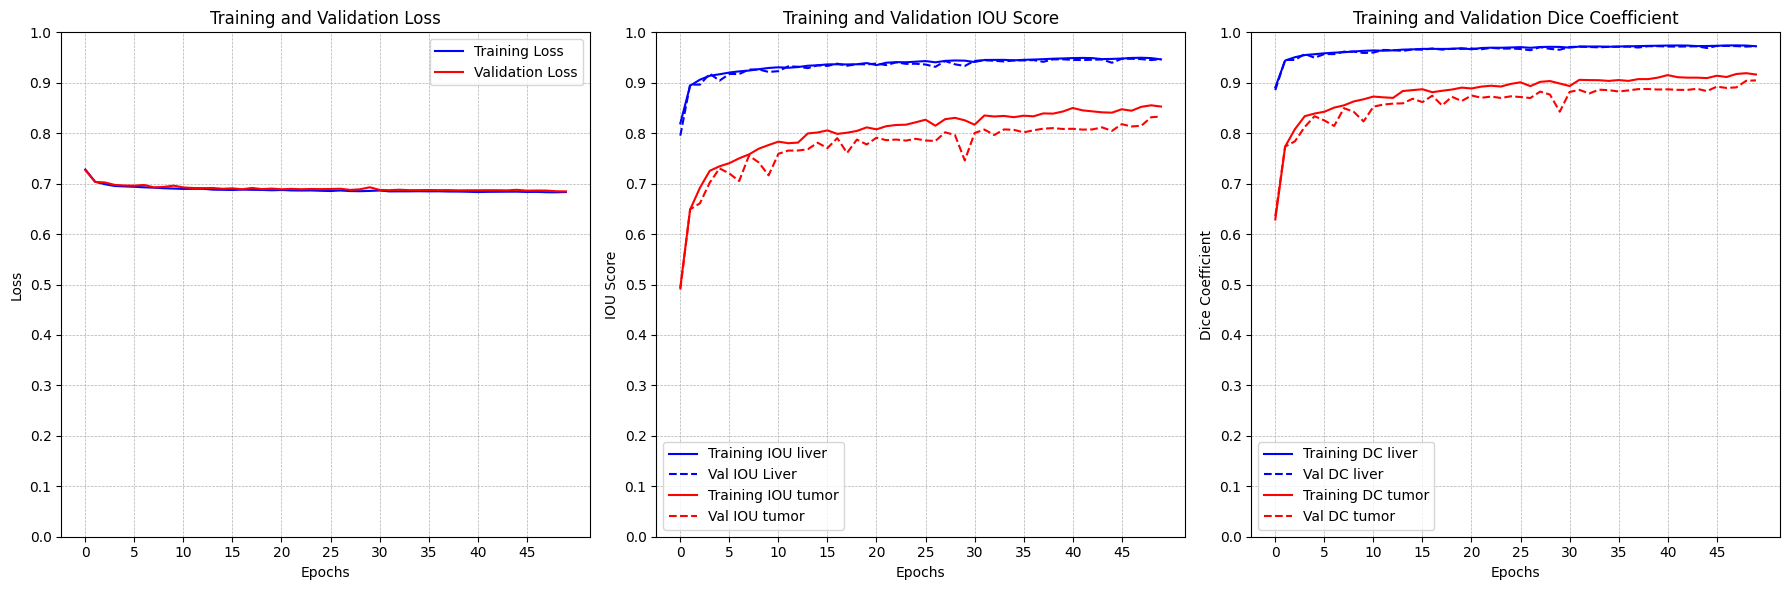

In [27]:
# im using the log data from the last commit
from matplotlib import pyplot as plt
history = pd.read_csv('/kaggle/working/training_log_WNet_Res50_AT', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score_tumor=history['iou_tumor']
val_iou_score_tumor=history['val_iou_tumor']

iou_score_liver=history['iou_liver']
val_iou_score_liver=history['val_iou_liver']

loss=history['loss']
val_loss=history['val_loss']

train_dice_tumor=history['dice_coef_tumor']
val_dice_tumor=history['val_dice_coef_tumor']

train_dice_liver=history['dice_coef_liver']
val_dice_liver=history['val_dice_coef_liver']


epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score_liver, 'b', label='Training IOU liver', linewidth=1.5)
axes[1].plot(epoch, val_iou_score_liver, 'b--', label='Val IOU Liver', linewidth=1.5)
axes[1].plot(epoch, iou_score_tumor, 'r', label='Training IOU tumor', linewidth=1.5)
axes[1].plot(epoch, val_iou_score_tumor, 'r--', label='Val IOU tumor', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice_liver, 'b', label='Training DC liver', linewidth=1.5)
axes[2].plot(epoch, val_dice_liver, 'b--', label='Val DC liver', linewidth=1.5)
axes[2].plot(epoch, train_dice_tumor, 'r', label='Training DC tumor', linewidth=1.5)
axes[2].plot(epoch, val_dice_tumor, 'r--', label='Val DC tumor', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()


# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Fine-tuning Joint updation

Im going for this method instead...more efficient

In [28]:
model = build_WNet((256,256,3))

In [29]:
model.load_weights("/kaggle/working/WNet_Res50_AT.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001), loss=total_loss,
              metrics = {"output_1":[dice_coef_liver,dice_coef_tumor,iou_liver,iou_tumor,sensitivity_liver,sensitivity_tumor,specificity_liver,specificity_tumor]})


In [30]:
model.get_layer("encoder1").trainable = True
model.get_layer("encoder2").trainable = True

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('/kaggle/working/training_log_WNet_Res50_AT', separator=',', append=True)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=3
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/WNet_Res50_AT_fine_tuned.h5", 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
                              
"""reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.3
                             )"""
callbacks = [checkpointer, reduce_lr, csv_logger]

In [32]:
batch_size = 16
N = 256
train_generator = CustomDataGenerator(df_train, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(df_val, batch_size=batch_size, image_size=(N,N), shuffle=False)
history_ = model.fit(train_generator, steps_per_epoch=len(df_train) // batch_size,
                    validation_data=val_generator, validation_steps=len(df_val) // batch_size,
                    epochs=10,callbacks=callbacks)

Epoch 1/10


2024-01-21 19:00:15.409252: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/encoder1/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


836/836 [==============================] - ETA: 0s - loss: 0.6822 - dice_coef_liver: 0.9742 - dice_coef_tumor: 0.9242 - iou_liver: 0.9498 - iou_tumor: 0.8643 - sensitivity_liver: 0.9771 - sensitivity_tumor: 0.9199 - specificity_liver: 0.9983 - specificity_tumor: 0.9998
Epoch 1: val_loss improved from inf to 0.68384, saving model to /kaggle/working/WNet_Res50_AT_fine_tuned.h5
836/836 [==============================] - 604s 658ms/step - loss: 0.6822 - dice_coef_liver: 0.9742 - dice_coef_tumor: 0.9242 - iou_liver: 0.9498 - iou_tumor: 0.8643 - sensitivity_liver: 0.9771 - sensitivity_tumor: 0.9199 - specificity_liver: 0.9983 - specificity_tumor: 0.9998 - val_loss: 0.6838 - val_dice_coef_liver: 0.9734 - val_dice_coef_tumor: 0.9112 - val_iou_liver: 0.9482 - val_iou_tumor: 0.8422 - val_sensitivity_liver: 0.9782 - val_sensitivity_tumor: 0.9169 - val_specificity_liver: 0.9981 - val_specificity_tumor: 0.9997 - lr: 1.0000e-05
Epoch 2/10
836/836 [==============================] - ETA: 0s - loss: 0.

In [33]:
# Save the final trained model
model.save('final_model_WNet_Res50_AT_fine_tuned.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


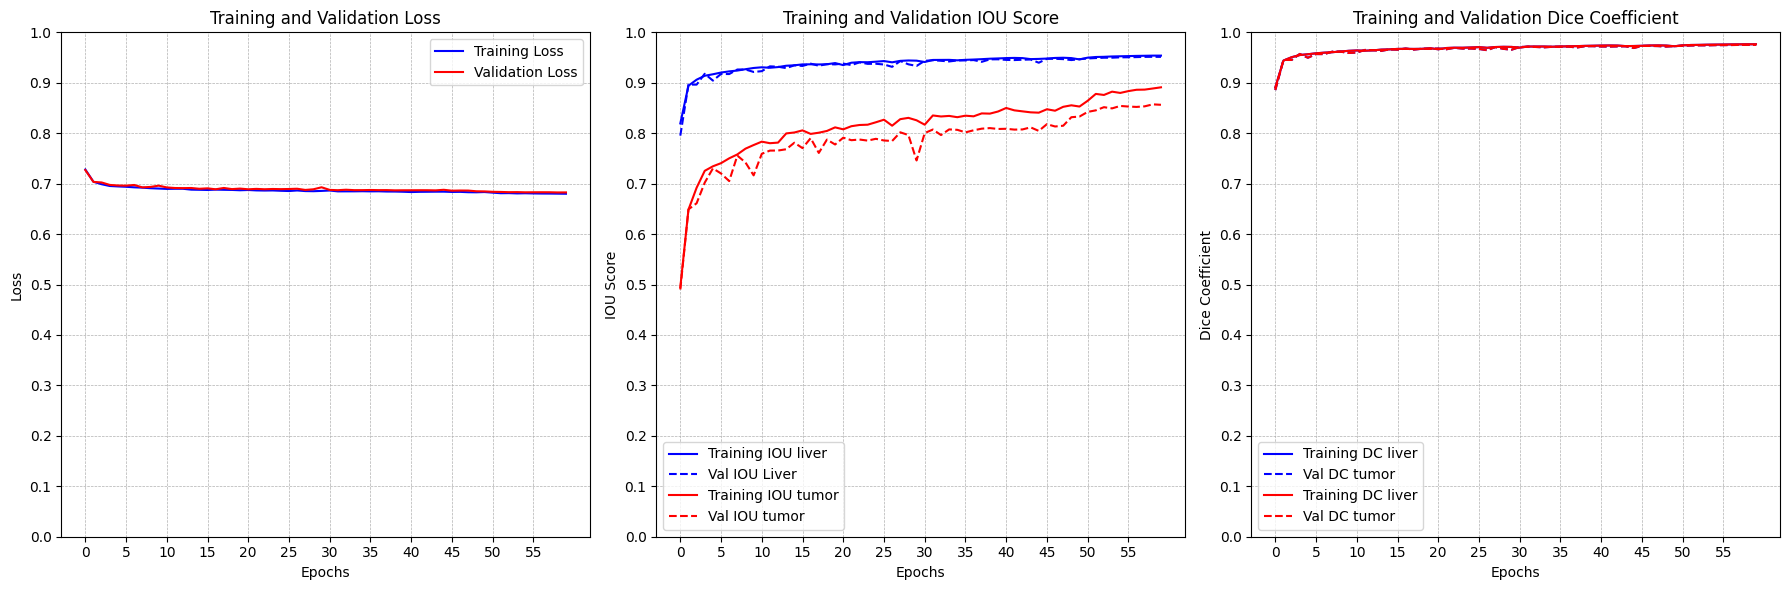

In [34]:
from matplotlib import pyplot as plt
history = pd.read_csv('/kaggle/working/training_log_WNet_Res50_AT', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score_tumor=history['iou_tumor']
val_iou_score_tumor=history['val_iou_tumor']

iou_score_liver=history['iou_liver']
val_iou_score_liver=history['val_iou_liver']

loss=history['loss']
val_loss=history['val_loss']

train_dice_tumor=history['dice_coef_tumor']
val_dice_tumor=history['val_dice_coef_tumor']

train_dice_liver=history['dice_coef_liver']
val_dice_liver=history['val_dice_coef_liver']


epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score_liver, 'b', label='Training IOU liver', linewidth=1.5)
axes[1].plot(epoch, val_iou_score_liver, 'b--', label='Val IOU Liver', linewidth=1.5)
axes[1].plot(epoch, iou_score_tumor, 'r', label='Training IOU tumor', linewidth=1.5)
axes[1].plot(epoch, val_iou_score_tumor, 'r--', label='Val IOU tumor', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice_liver, 'b', label='Training DC liver', linewidth=1.5)
axes[2].plot(epoch, val_dice_liver, 'b--', label='Val DC tumor', linewidth=1.5)
axes[2].plot(epoch, train_dice_liver, 'r', label='Training DC liver', linewidth=1.5)
axes[2].plot(epoch, val_dice_liver, 'r--', label='Val DC tumor', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()


# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Testing Model

In [35]:
#for multiclass
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                #mask = mask.astype(np.int32)
    

            """augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])"""
            images.append(image)
            masks.append(mask)
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        #masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        masks = np.array(tf.one_hot(masks, 3, dtype = tf.float32))
        return  images, masks

# Example usage of the CustomDataGenerator
test_generator = CustomDataGenerator(df_test, batch_size=16, image_size=(256, 256), shuffle=True)


In [36]:
results = model.evaluate(test_generator)

216/216 [==============================] - 132s 613ms/step - loss: 0.6828 - dice_coef_liver: 0.9745 - dice_coef_tumor: 0.9183 - iou_liver: 0.9503 - iou_tumor: 0.8577 - sensitivity_liver: 0.9785 - sensitivity_tumor: 0.9185 - specificity_liver: 0.9982 - specificity_tumor: 0.9998


In [37]:
#!zip -r weights_WNet_Res50_AT_CL.zip /kaggle/working/WNet_maxpool.h5

In [38]:
#from IPython.display import FileLink
#FileLink(r'weights_WNet_Res50_AT_CL.zip')